# Ex14

In [ ]:
!pip install  --upgrade tensorflow==2.6.0
!pip install keras==2.6

In [2]:
import tensorflow as tf
import pandas as pd
import re
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

### 데이터 수집하기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
chat_path = "/content/drive/MyDrive/transformer_chatbot/ChatbotData .csv"
chat = pd.read_csv(chat_path)

In [5]:
print(chat)

                             Q                         A  label
0                       12시 땡!                하루가 또 가네요.      0
1                  1지망 학교 떨어졌어                 위로해 드립니다.      0
2                 3박4일 놀러가고 싶다               여행은 언제나 좋죠.      0
3              3박4일 정도 놀러가고 싶다               여행은 언제나 좋죠.      0
4                      PPL 심하네                눈살이 찌푸려지죠.      0
...                        ...                       ...    ...
11818           훔쳐보는 것도 눈치 보임.        티가 나니까 눈치가 보이는 거죠!      2
11819           훔쳐보는 것도 눈치 보임.             훔쳐보는 거 티나나봐요.      2
11820              흑기사 해주는 짝남.                    설렜겠어요.      2
11821  힘든 연애 좋은 연애라는게 무슨 차이일까?  잘 헤어질 수 있는 사이 여부인 거 같아요.      2
11822               힘들어서 결혼할까봐        도피성 결혼은 하지 않길 바라요.      2

[11823 rows x 3 columns]


열에 이름을 보기싶게 바꿔주겠다. 그리고 필요없는 열을 삭제해주겠다.

In [6]:
chat.rename(columns={'Q':'question'}, inplace=True)
chat.rename(columns={'A':'answer'}, inplace=True)
chat = chat[['question', 'answer']]

In [7]:
chat.head()

,question,answer
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


오늘은 질문과 답을 나누어 학습을 해야하므로 데이터를 분리시키겠다.

In [8]:
chat_question = chat['question']
chat_answer = chat['answer']
print('전체 샘플 수 :', len(chat_question))
print('전체 샘플 수 :', len(chat_answer))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


### 데이터 전처리하기

우선 언어에서의 기본적인 전처리를 하자.

한글과 !?,.이 4개의 구두점을 제외하고 모든 특수 문자를 제거하겠다.

In [45]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_punc(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return chat.apply(lambda x: x.str.strip(), axis = 1)

def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts)) #remove punctuation
        review = re.sub(r'\d+','', str(texts[i]))# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove extra space
        review = re.sub(r'<[^>]+>','',review) #remove Html tags
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        review = re.sub(r"[a-zA-Z]+", " ", review)
        corpus.append(review)
    return corpus

clean_punc(chat, punct, punct_mapping)
clean_text(chat_question)
clean_text(chat_answer)


['하루가 또 가네요.',
 '위로해 드립니다.',
 '여행은 언제나 좋죠.',
 '여행은 언제나 좋죠.',
 '눈살이 찌푸려지죠.',
 '다시 새로 사는 게 마음 편해요.',
 '다시 새로 사는 게 마음 편해요.',
 '잘 모르고 있을 수도 있어요.',
 '시간을 정하고 해보세요.',
 '시간을 정하고 해보세요.',
 '자랑하는 자리니까요.',
 '그 사람도 그럴 거예요.',
 '그 사람도 그럴 거예요.',
 '혼자를 즐기세요.',
 '돈은 다시 들어올 거예요.',
 '땀을 식혀주세요.',
 '어서 잊고 새출발 하세요.',
 '빨리 집에 돌아가서 끄고 나오세요.',
 '빨리 집에 돌아가서 끄고 나오세요.',
 '다음 달에는 더 절약해봐요.',
 '따뜻하게 사세요!',
 '다음 달에는 더 절약해봐요.',
 '가장 확실한 시간은 오늘이에요. 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '더 가까워질 기회가 되겠네요.',
 '저도요.',
 '다들 바빠서 이야기할 시간이 부족했나봐요.',
 '다들 바빠서 이야기할 시간이 부족했나봐요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '좋은 생각이에요.',
 '더 가까워질 기회가 되겠네요.',
 '저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '좋은 생각이에요.',
 '정말 후회할 습관이에요.',
 '무모한 결정을 내리지 마세요.',
 '선생님이나 기관에 연락해보세요.',
 '떨리는 감정은 그 자체로 소중해요.',
 '득템했길 바라요.',
 '휴식도 필요하죠.',
 '단짠으로 두 개 사는게 진리죠.',
 '단짠으로 두

의도한대로 전처리가 잘 되었다는 것을 알 수 있다. 

전처리 할 때 샘플의 수가 줄었는 지 확인해보자.

In [47]:
print('전체 샘플 수 :', len(chat_question))
print('전체 샘플 수 :', len(chat_answer))
print('전처리 후의 22번째 질문 샘플: {}'.format(chat_question[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(chat_answer[21]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823
전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요.


#### 병렬 데이터 전처리하기

순서

1. TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.

2. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩 한다.

3. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.

4. 최대 길이 MAX_LENGTH을 넘는 문장들은 필터링한다.

5. MAX_LEMGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩한다.


##### 1. 단어장(Vocabulary) 만들기

우선 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어 보겠다. 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만든다.

In [11]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(chat_question + chat_answer, target_vocab_size=2**13)

이때 디코더의 문장 생성 과정에서 사용할 '시작토큰'과 '종료토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해준다. 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여하면 되겠다.

In [12]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8361]
END_TOKEN의 번호 : [8362]


각각 8,361과 8,362라는 점에서 현재 단어장의 크기가 8,361(0번부터 8,360번)이라는 의미이다.

두개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 한다.

In [13]:
#시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8363


##### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

예를 들어서 22번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 보자.

In [14]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(chat_question[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(chat_answer[21])))

정수 인코딩 후의 21번째 질문 샘플: [5824, 602, 2498, 4170]
정수 인코딩 후의 21번째 답변 샘플: [2683, 7666, 6, 6375, 92, 8151]


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있다. 위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 정수 인코딩을 수행한다. 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 패딩(Padding)한다.

In [15]:
question_len = [len(s.split()) for s in chat_question]
answer_len = [len(s.split()) for s in chat_answer]

print('질문의 최대 길이 : {}'.format(np.max(question_len)))
print('대답의 최대 길이 : {}'.format(np.max(answer_len)))

질문의 최대 길이 : 15
대답의 최대 길이 : 21


In [16]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 21

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

question, answer = tokenize_and_filter(chat_question, chat_answer)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(question)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answer)))

단어장의 크기 : 8363
필터링 후의 질문 샘플 개수: 11800
필터링 후의 답변 샘플 개수: 11800


##### 3, 교사 강요 사용하기

In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': question,
        'dec_inputs': answer[:, :-1]
    },
    {
        'outputs': answer[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 정의 및 학습하기

인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의한다.

우선 인코더 함수

포지셔널 인코딩

트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받는다. 트랜스포머가 RNN과 결정적이 다른 점이 바로 이 부분이다. RNN에는 어차피 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순 정보를 알려줄 필요가 없다. 그러나 문장에 있는 모든 단어를 한꺼번에 문장 단위로 입력받는 트랜스포머는 자칫 'I ate lunch'와 'lunch ate I'를 구분할 수 없을지도 모른다. 그래서 같은 단어라도 그 단어가 문장의 몇번째 어순으로 입력으로되었는 지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터 값을 더해서 모델의 입력으로 삼는 것이다.

In [19]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

어텐션 함수는 주어진 쿼리에 대해서 모든 키와의 유사도를 각각 구한다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(value)'에 반영해 준다. 그리고 유사도가 반영된 '값(value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 '어텐션 값(Attention Value)라고 한다.

이 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나눠주고, 유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용한다. 


In [18]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

병렬 어텐션

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

마스킹 : 문장 길이를 맞춰주기 위한 작업

In [21]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [22]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

인코더

하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어진다.

바로 셀프 어텐션과 피드 포워드 신경망이다. 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어져있다.

두개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같다. 함수 내부적으로 첫번째 서브 층과 두번째 서브층을 구현하고 있다.

In [23]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

인코더 층을 쌓아 인코더 만들기

이렇게 구현한 인코더 층을 임베딩 층(Embedding layer)과 포지셔널 인코딩(Positional Encoding)을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.

트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓았다

In [24]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

디코더 함수

첫번째 셀프 어텐션, 두번째는 인코더-디코더 어텐션, 세번째는 피드 포워드 신경망이다. 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 key와 Value가 인코더의 벡터라는 특징이 있다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정이다.

인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행한다.

In [25]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

디코더 층을 쌓아 디코더 만들기

이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer)과 포지셔널 인코딩(Positional Encoding)을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다.

인코더와 마찬가지로 num_layers 개수와 디코더 층을 쌓았다.

In [26]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

이제 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의한다.

In [27]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

모델 생성

num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값이다.

논문에서 num_layers는 6, d-Model은 512를 그대로 적용해보겠다.

In [28]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13749760    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

손실함수

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [29]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


커스텀 된 학습률

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터이다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 한다.

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 봅시다. 위에 언급한 수식은 step_num **-0.5에 비례하는 부분과 step_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있다. 그래서 학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있다.

Text(0.5, 0, 'Train Step')

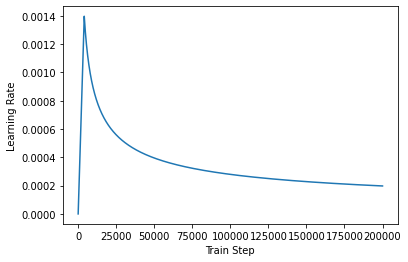

In [31]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

모델 컴파일

손실함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일한다.

In [32]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

훈련하기

In [33]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
185/185 [==============================] - 48s 164ms/step - loss: 2.6200 - accuracy: 0.0476
Epoch 2/100
185/185 [==============================] - 24s 127ms/step - loss: 2.0889 - accuracy: 0.0965
Epoch 3/100
185/185 [==============================] - 24s 127ms/step - loss: 1.9110 - accuracy: 0.0989
Epoch 4/100
185/185 [==============================] - 24s 130ms/step - loss: 1.8240 - accuracy: 0.1029
Epoch 5/100
185/185 [==============================] - 24s 130ms/step - loss: 1.7557 - accuracy: 0.1073
Epoch 6/100
185/185 [==============================] - 24s 127ms/step - loss: 1.6828 - accuracy: 0.1109
Epoch 7/100
185/185 [==============================] - 23s 126ms/step - loss: 1.6039 - accuracy: 0.1155
Epoch 8/100
185/185 [==============================] - 23s 127ms/step - loss: 1.5107 - accuracy: 0.1214
Epoch 9/100
185/185 [==============================] - 23s 126ms/step - loss: 1.4039 - accuracy: 0.1295
Epoch 10/100
185/185 [==============================] - 24s 127m

챗봇 테스트하기

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다.

세로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.

입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.

패딩 마스킹과 룩 어헤드 마스킹을 계산한다.

디코더는 입력 시퀀스로부터 다음 단어를 예측한다.

디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.

END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 decoder_inference() 함수를 만든다.

In [53]:
def decoder_inference(sentence):
  #sentence = clean_text(sentence)
  sentence = ''.join(clean_text(sentence))

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [40]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))


In [52]:
sentence = '가스비 장난 아님'
sentence = ''.join(clean_text(sentence))

# 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
# ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
sentence = tf.expand_dims(
    START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

# 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
# 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
output_sequence = tf.expand_dims(START_TOKEN, 0)

# 디코더의 인퍼런스 단계
for i in range(MAX_LENGTH):
  # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
  predictions = model(inputs=[sentence, output_sequence], training=False)
  predictions = predictions[:, -1:, :]

  # 현재 예측한 단어의 정수
  predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

  # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
  if tf.equal(predicted_id, END_TOKEN[0]):
    break

  # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
  # 이 output_sequence는 다시 디코더의 입력이 됩니다.
  output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)


In [61]:
sentence_generation('어떡하지')

입력 : 어떡하지
출력 : 어떡하면 좋을까요.


In [55]:
sentence_generation('고기 먹고 싶다')

입력 : 고기 먹고 싶다
출력 : 저기압에는 고기앞이죠.


출력 값이 마음에 들지 않는다. 모델 학습 더 시켜봐야지.

In [62]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
185/185 [==============================] - 24s 129ms/step - loss: 0.0322 - accuracy: 0.3311
Epoch 2/100
185/185 [==============================] - 24s 130ms/step - loss: 0.0328 - accuracy: 0.3308
Epoch 3/100
185/185 [==============================] - 23s 126ms/step - loss: 0.0315 - accuracy: 0.3311
Epoch 4/100
185/185 [==============================] - 23s 126ms/step - loss: 0.0304 - accuracy: 0.3315
Epoch 5/100
185/185 [==============================] - 23s 126ms/step - loss: 0.0303 - accuracy: 0.3316
Epoch 6/100
185/185 [==============================] - 24s 129ms/step - loss: 0.0299 - accuracy: 0.3315
Epoch 7/100
185/185 [==============================] - 23s 126ms/step - loss: 0.0296 - accuracy: 0.3318
Epoch 8/100
185/185 [==============================] - 23s 126ms/step - loss: 0.0293 - accuracy: 0.3319
Epoch 9/100
185/185 [==============================] - 23s 126ms/step - loss: 0.0293 - accuracy: 0.3319
Epoch 10/100
185/185 [==============================] - 24s 129m

In [63]:
sentence_generation('안녕')

입력 : 안녕
출력 : 안녕하세요.


In [78]:
sentence_generation('심심하다')

입력 : 심심하다
출력 : 저랑 놀아요.


In [79]:
sentence_generation('그나저나')

입력 : 그나저나
출력 : 어느덧 두달이 지났네요.


In [83]:
sentence_generation('퇴사하고 싶다.')

입력 : 퇴사하고 싶다.
출력 : 기분이 좀 풀렸길 바랍니다.


In [90]:
sentence_generation('할머니 보고싶다.')

입력 : 할머니 보고싶다.
출력 : 가면 저도 데려가세요.


In [93]:
sentence_generation('잘생겼다.')

입력 : 잘생겼다.
출력 : 네 잘생겼어요.


In [95]:
sentence_generation('너 이름이 뭐니?')

입력 : 너 이름이 뭐니?
출력 : 날씨 어플에 물어보세요.


바보 같으면서도 바보가 아닌 이상한 어플

### 출처

https://ebbnflow.tistory.com/246

### 회고

재밌다.

근데 의문 점은 loss는 낮는 데 accuracy는 왜 안 높아질까? 이게 참 궁금하다. 다음에 원인을 찾고 다시 구현해봐야지.